# Image Classification using fully connected layers
In this notebook, a Neural Network using fully connected layers will be build from scratch and trained on the MNIST dataset. The MNIST dataset is a dataset containing hand-written images of digits. The end goal is to label the images with their corresponding digit. 

In [1]:
# Imports
import copy
import torch
import random
import numpy as np
import torch.nn as nn 
from torch.optim import SGD 
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.datasets as datasets 
import torchvision.transforms as transforms
from torchmetrics.classification import MulticlassAccuracy 
from torch.utils.data import Dataset, DataLoader, random_split


c:\python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


c:\python39\lib\site-packages\torchaudio\backend\utils.py:66: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


## Dataset analysis
In this part, the dataset is loaded and a preview of an image is shown. The training set (train=true) and test set (train=false) are loaded from the default datasets offered by PyTorch. When loading a dataset like this, images can already be transformed. In order for an image to be processed by a neural network, it always needs to be converted to a Tensor. Also when training neural networks, it is good practice to normalize the images to speed up the training process. We do this by defining the transforms and passing them to the dataset downloader. 

In [2]:
# Define transforms that will be applied to the downloaded images
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])

# Load MNIST training and test dataset
mnist_trainset = datasets.MNIST(root='../../data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='../../data', train=False, download=True, transform=transform)

In PyTorch, data can be extracted from the dataset using data loaders. These loaders can extract the data in batches and can also do this in a random fashion to prevent repetition in the data. The size of the batch can be passed as a parameter. 

In [3]:
# Create dataloaders
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=10, shuffle=True)
valid_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=10, shuffle=True)

# Create a total dataloader dictionary
dataloaders = {'train': train_loader, 'valid': valid_loader}

We can extract a batch from the dataset using the data loaders. Each entry of the batch contains an input (the image) and an output (the label). 

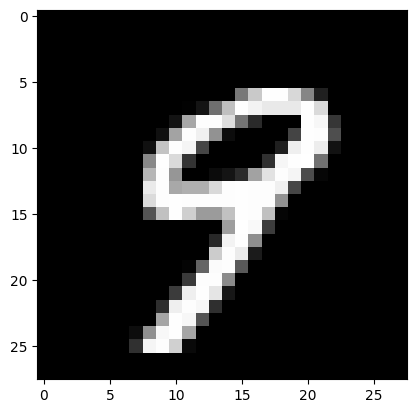

The batch contains 10 samples.
The labels that belong to the images are: tensor([9, 1, 5, 8, 2, 8, 1, 4, 7, 9])
The label that belongs to the first image is: 9


In [4]:
# Extract a batch
batch = next(iter(train_loader))

# Extract the images and labels
x, y = batch

# Convert the fist image tensor to an array
image = x[0].permute(1,2,0)

# Show image
plt.imshow(image, cmap='gray')
plt.show()

# Print results
print("The batch contains " + str(len(x)) + " samples.")
print("The labels that belong to the images are: " + str(y))
print("The label that belongs to the first image is: " + str(y[0].item()))

## Creating the neural network model class
In this section, a class object of the Neural Network will be created. In this example, the first layer transforms 28² elements to 100 elements. The second layer transforms 100 elements to 50 elements. The last layer transforms 50 elements to 10 elements. These 10 elements represent the probabilities of being the i-th digit of the vector.

In [5]:
# Create the neural net class
class NeuralNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(28*28, 100) # This fully connected layer has 28*28 inputs and 100 outputs (100 neurons)
        self.linear2 = nn.Linear(100, 50) # This fully connected layer has 100 inputs (from the previous layer) and 50 outputs (50 neurons)
        self.linear3 = nn.Linear(50, 10) # This fully connected layer has 50 inputs (from the previous layer) and 10 outputs (10 neurons) which represent the 10 classes
        self.R = nn.ReLU() # The neuron activation of each layer 

    # This function executs the forward pass of an image x to the neural net
    def forward(self,x):
        x = x.view(-1, 28**2) # First it flattens the image of 28 by 28 to a vector of 28*28 elements because we have a fully connected layer at the beginning
        x = self.R(self.linear1(x)) # Passing the vector to the first layer, activating the results, and obtaining the outputs
        x = self.R(self.linear2(x)) # Passing the outputs of the previous layer to the second layer, activating the results, and obtaining the outputs
        x = self.linear3(x) # Passing the outputs of the previous layer to the final layer and obtaining the outputs
        return x

# Create the neural net object
model = NeuralNet()

## Model training
A function is created to automize the training of the Fully connected Neural Network. 

In [6]:
# Search for the available training device on the computer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
def train_model(model, optimizer, criterum, n_epochs=20):

    # Learning curves
    results = {"training_acc": [], "training_loss": [], "validation_acc": [], "validation_loss": []}

    # Loop over all epochs
    best_loss = float('inf')
    for epoch in range(n_epochs):

        # Debug
        print('Epoch {}/{}'.format(epoch+1, n_epochs))
        print('-'*10)

        # Each epoch has a training and validation phase
        for phase in ['train','valid']:

            # Set the network state dependent on the phase
            if phase == 'train':
                model.train()
            else:
                model.eval()

            # Reset the losses and corrects at the start of each epoch
            running_loss = 0.0
            running_corrects = 0.0

            # Extract batches from the data loaders untill all batches are retrieved
            num_samples = 0
            for inputs, labels in dataloaders[phase]:

                # Inputs shape
                batch_size, c, h, w = inputs.shape

                # Store the inputs and labels to the selected device
                inputs = inputs.to(device)  
                labels = labels.to(device)  

                # Forward pass through the network
                outputs = model(inputs)

                # Softmax transforms the output probabilities into one selected class
                _, class_pred = torch.max(outputs, 1)

                # Compute the loss of the batch
                loss = criterium(outputs, labels)
                
                # Update the losses and corrects for this batch
                running_loss += loss.item() * batch_size
                running_corrects += class_pred.eq(labels).sum().item()

                # Calculate total samples
                num_samples += batch_size

                # If in training phase, adapt the model paramters to account for the losses
                if phase=='train':
                    optimizer.zero_grad() # Pytorch keeps track of the gradients over multiple epochs, therefore initialise it to 0
                    loss.backward() # Calculate the weight gradients (Backward Propagation)
                    optimizer.step() # Update the model parameters using the defined optimizer 
                    
            # Save results
            if phase == 'train':
                results['training_acc'].append((running_corrects/num_samples)*100)
                results['training_loss'].append(running_loss/num_samples)
                print("train_acc %.3f train_loss %.3f" % (running_corrects/num_samples, running_loss/num_samples))
            elif phase == 'valid':
                results['validation_acc'].append((running_corrects/num_samples)*100)
                results['validation_loss'].append(running_loss/num_samples)
                print("val_acc %.3f val_loss %.3f" % (running_corrects/num_samples, running_loss/num_samples))

            # Save model
            if phase=='valid' and loss < best_loss:
                torch.save(model, '../../models/classification_model.pt')
                best_loss = loss

    return results

In [8]:
# Set the optimizer
optimizer = SGD(model.parameters(), lr=0.001)

# Set the loss function
criterium = nn.CrossEntropyLoss()

# Train for 50 epochs
results = train_model(model, optimizer, criterium, n_epochs=10)

Epoch 1/10
----------


train_acc 0.591 train_loss 1.443


val_acc 0.835 val_loss 0.645
Epoch 2/10
----------


train_acc 0.861 train_loss 0.503


val_acc 0.888 val_loss 0.397
Epoch 3/10
----------


train_acc 0.891 train_loss 0.380


val_acc 0.904 val_loss 0.338
Epoch 4/10
----------


train_acc 0.903 train_loss 0.337


val_acc 0.911 val_loss 0.310
Epoch 5/10
----------


train_acc 0.909 train_loss 0.313


val_acc 0.918 val_loss 0.291
Epoch 6/10
----------


train_acc 0.915 train_loss 0.295


val_acc 0.922 val_loss 0.281
Epoch 7/10
----------


train_acc 0.919 train_loss 0.280


val_acc 0.926 val_loss 0.268
Epoch 8/10
----------


train_acc 0.923 train_loss 0.266


val_acc 0.929 val_loss 0.252
Epoch 9/10
----------


train_acc 0.927 train_loss 0.253


val_acc 0.931 val_loss 0.243
Epoch 10/10
----------


train_acc 0.930 train_loss 0.241


val_acc 0.934 val_loss 0.231


The validation loss function is plotted for each epoch during the training procedure. It is clear that the loss becomes smaller as the amount of epochs progresses. The validation loss keeps decreasing, thus overfitting does not occur here.

Text(0.5, 1.0, 'Accuracy')

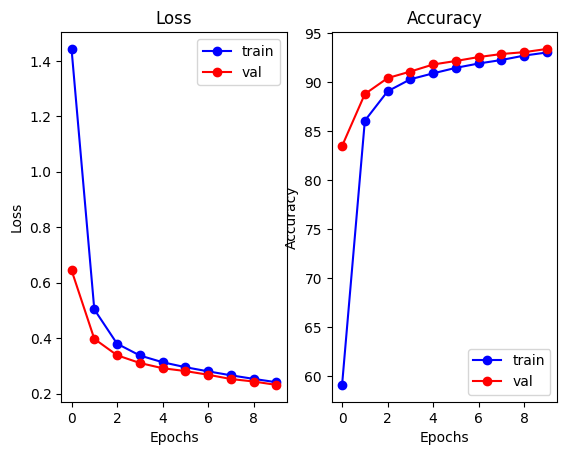

In [9]:
# Plot results
plt.subplot(1, 2, 1)
plt.plot(range(len(results['training_loss'])), results['training_loss'], 'bo-', label='train')
plt.plot(range(len(results['validation_loss'])), results['validation_loss'], 'ro-', label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(len(results['training_acc'])), results['training_acc'], 'bo-', label='train')
plt.plot(range(len(results['validation_acc'])), results['validation_acc'], 'ro-', label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')

## Model validation

To validate the model we can compare the predicted value of an image to the ground thruth. We can do this for the first image in the batch that we extracted earlier. 

In [10]:
# Predicted label of the sampel image
y_pred = model(x[0])
_, class_pred = torch.max(y_pred, 1)

# The true label
y_true = y

# Print result
print("The model predicts the number to be " + str(class_pred.item()) + " and the real number is " + str(y_true[0].item()))

The model predicts the number to be 9 and the real number is 9


We can also validate for the whole batch. 

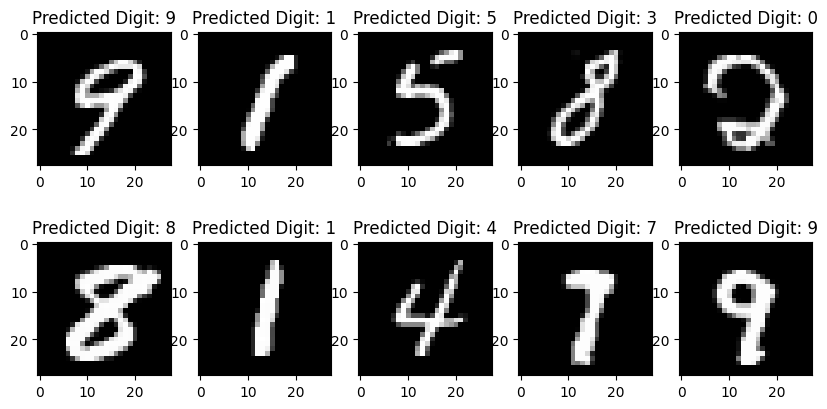

In [11]:
# Get the predictions for the whole batch
y_pred = model(x).argmax(axis=1)

# Plot predictions and labels
fig, ax = plt.subplots(2,5,figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x[i].permute(1,2,0), cmap='gray')
    plt.title(f'Predicted Digit: {y_pred[i]}')
plt.show()

In [12]:
# Reset the losses and corrects at the start of each epoch
running_corrects = 0.0

# Extract batches from the data loaders untill all batches are retrieved
num_samples = 0
for inputs, labels in valid_loader:

    # Inputs shape
    batch_size, c, h, w = inputs.shape

    # Store the inputs and labels to the selected device
    inputs = inputs.to(device)  
    labels = labels.to(device)  

    # Forward pass through the network
    outputs = model(inputs)

    # Softmax transforms the output probabilities into one selected class
    _, class_pred = torch.max(outputs, 1)
    
    # Update the losses and corrects for this batch
    running_corrects += class_pred.eq(labels).sum().item()

    # Calculate total samples
    num_samples += batch_size

# Print results
print('The model has an accuracy of ' + str((running_corrects/num_samples)*100) + ' on the validation set.')

The model has an accuracy of 93.41000000000001 on the validation set.
